Indeed, two people can never have the same fingerprints, it is unique in every human. But using fingerprints we can classify gender, whether it’s male or female. 

In this file, we will work on Gender Classification Model which we will train using Deep Learning and Convolutional Neural Networks.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will build a Convolutional Neural Network that can classify the gender using the fingerprints. For this task, we will use a dataset that contains over 55000 images of fingerprints of each finger.

### Gender Classification using Fingerprints

We will first start with converting those images into pixels value to extract the features from the fingerprints. Then we will split the data into training, testing and validation sets.

In [5]:
#import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt

In [6]:
#Function to extract labels for both real and altered images
def extract_label(img_path,train = True):
  filename, _ = os.path.splitext(os.path.basename(img_path))

  subject_id, etc = filename.split('__')
  #For Altered folder
  if train:
      gender, lr, finger, _, _ = etc.split('_')
  #For Real folder
  else:
      gender, lr, finger, _ = etc.split('_')
  
  gender = 0 if gender == 'M' else 1
  lr = 0 if lr == 'Left' else 1

  if finger == 'thumb':
      finger = 0
  elif finger == 'index':
      finger = 1
  elif finger == 'middle':
      finger = 2
  elif finger == 'ring':
      finger = 3
  elif finger == 'little':
      finger = 4
  return np.array([gender], dtype=np.uint16)

The above function will help us in extracting the features from the fingerprints. This function will work by iterating through the labels of the images that we will assign in the function. The function will return an **array 0 and 1**. 
* The zeros will represent males and 
* ones will be representing the females.

Our next step is to load the image path to the function we created to iterate all over the images to find labels. We can download the dataset from [here](https://www.kaggle.com/ruizgara/socofing):

In [7]:
img_size = 96
#Function to iterate through all the images
def loading_data(path,train):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    data
    return data

Now, the next step is to assign various directories or folders to use the loading data function on all the images:

In [8]:
Real_path = "/content/drive/MyDrive/gender/Real"
Easy_path = "/content/drive/MyDrive/gender/Altered-Easy"
Medium_path = "/content/drive/MyDrive/gender/Altered-Medium"
Hard_path = "/content/drive/MyDrive/gender/Altered-Hard"

Easy_data = loading_data(Easy_path, train = True)
Medium_data = loading_data(Medium_path, train = True)
Hard_data = loading_data(Hard_path, train = True)
test = loading_data(Real_path, train = False)

data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)

del Easy_data, Medium_data, Hard_data

loading data from:  /content/drive/MyDrive/gender/Altered-Easy
loading data from:  /content/drive/MyDrive/gender/Altered-Medium
loading data from:  /content/drive/MyDrive/gender/Altered-Hard
loading data from:  /content/drive/MyDrive/gender/Real


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Let’s randomize the data and test the arrays to see what our data looks like:

In [9]:
import random
random.shuffle(data)
random.shuffle(test)

The output above is showing how our images are present in the data. 
* The first array is representing the label value of `0` and 
* Then we have an array of pixel values. 

Don’t get confused, the above array is the real representation of how the computer sees an image. For example:

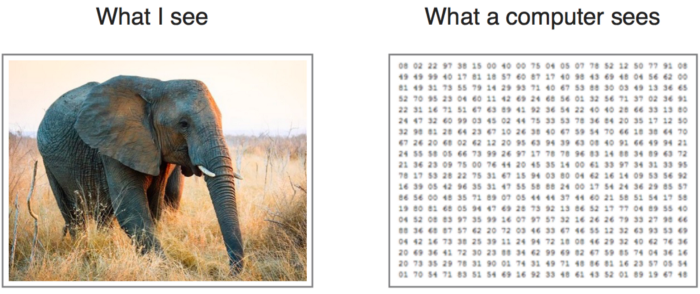

Now we will split the image arrays and image labels:

In [10]:
img, labels = [], []
for label, feature in data:
    labels.append(label)
    img.append(feature)
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0

from keras.utils.np_utils import to_categorical
train_labels = to_categorical(labels, num_classes = 2)
del data

### Building CNN for Gender Classification Model

In [11]:
#Import necessary libraries
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = Sequential([
                    Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [96, 96, 1]),
                    MaxPooling2D(2),
                    Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(2, activation = 'softmax'),
                    ])

Before moving forward, let’s have a quick look at the summary of our CNN Model:

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

Now, we will compile the model using **Adam optimizers**, with a **learning rate of 10%**, and to prevent our CNN model from overfitting. We will be using the `early_stopping_call` method:

In [13]:
model.compile(optimizer = optimizers.Adam(1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Let’s fit our Gender Classification Model. We are going to train the model for **30 epochs**.

In [14]:
history = model.fit(train_data, train_labels, batch_size = 128, epochs = 30, 
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)

Epoch 1/30
308/308 [==============================] - 47s 58ms/step - loss: 0.6460 - accuracy: 0.8129 - val_loss: 0.3486 - val_accuracy: 0.8531
Epoch 2/30
308/308 [==============================] - 17s 56ms/step - loss: 0.2246 - accuracy: 0.9124 - val_loss: 0.2057 - val_accuracy: 0.9231
Epoch 3/30
308/308 [==============================] - 17s 56ms/step - loss: 0.1056 - accuracy: 0.9650 - val_loss: 0.1506 - val_accuracy: 0.9457
Epoch 4/30
308/308 [==============================] - 17s 56ms/step - loss: 0.0506 - accuracy: 0.9850 - val_loss: 0.1065 - val_accuracy: 0.9629
Epoch 5/30
308/308 [==============================] - 16s 52ms/step - loss: 0.0298 - accuracy: 0.9920 - val_loss: 0.0998 - val_accuracy: 0.9682
Epoch 6/30
308/308 [==============================] - 16s 52ms/step - loss: 0.0174 - accuracy: 0.9962 - val_loss: 0.0963 - val_accuracy: 0.9653
Epoch 7/30
308/308 [==============================] - 16s 52ms/step - loss: 0.0115 - accuracy: 0.9978 - val_loss: 0.0968 - val_accuracy:

We will see a very long output for this of 30 epochs. It will use GPU, So we will recommend you to use **Google colab** for better performance. It will give train loss and accuracy and also validation loss and accuracy per epochs.

Now, we have successfully trained our CNN for Gender Classification Model with a **training accuracy of 99 percent** and **Validation accuracy of 98 percent**. Now, let’s have a look at the performance of our Gender Classification Model:

(0.0, 1.0)

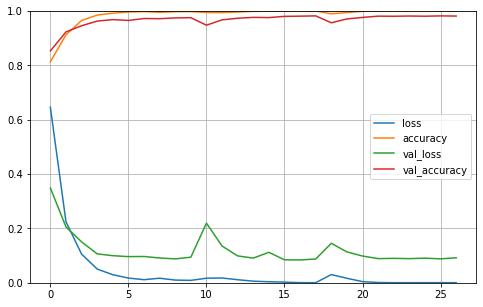

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

### Testing Gender Classification Model

As we split the training images into image labels and image arrays while training our model, we need to repeat the same process on the test images:

In [16]:
test_images, test_labels = [], []

for label, feature in test:
    test_images.append(feature)
    test_labels.append(label)
    
test_images = np.array(test_images).reshape(-1, img_size, img_size, 1)
test_images = test_images / 255.0
del test
test_labels  = to_categorical(test_labels, num_classes = 2)

Now, let’s evaluate the performance of our CNN model on the test set:

In [17]:
model.evaluate(test_images, test_labels)

188/188 [==============================] - 2s 10ms/step - loss: 0.0349 - accuracy: 0.9952


[0.034872688353061676, 0.9951666593551636]

So, we got an **accuracy of 99.72 percent** and a **loss value of 0.0126** on our gender classification model. 